In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('white')
sns.set_context('talk', font_scale = 1)
import os

import math
from transformers import BertTokenizer

In [2]:
startingDir = os.getcwd() # save our current directory
print(startingDir)
os.chdir('../') # moves the current working directory up one

from modeling_readmission import BertForSequenceClassification
import modeling_readmission

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/Users/nwams/Documents/Machine Learning Projects/ClinicalBERT/attention
in the modeling class


01/13/2020 14:47:08 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /Users/nwams/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [3]:
os.chdir(startingDir) # change back to where we started

In [4]:
bert_config = modeling_readmission.BertConfig.from_json_file('../model/early_readmission/bert_config.json')
model = BertForSequenceClassification(bert_config, 1)

In [5]:
bert_config

{
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

In [6]:
bert_config.num_attention_heads

12

In [7]:
dicts = model.load_state_dict(torch.load('../model/early_readmission/pytorch_model.bin', map_location='cpu'))

In [8]:
model.bert.encoder.layer[0].attention.self

BertSelfAttention(
  (query): Linear(in_features=768, out_features=768, bias=True)
  (key): Linear(in_features=768, out_features=768, bias=True)
  (value): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [9]:
def transpose_for_scores(config, x):
    new_x_shape = x.size()[:-1] + (config.num_attention_heads, int(config.hidden_size / config.num_attention_heads))
    x = x.view(*new_x_shape)
    return x.permute(0, 2, 1, 3)

In [10]:
def get_attention_scores(model,i,text):
    tokenized=tokenizer.tokenize(text)

    indexed_tokens=tokenizer.convert_tokens_to_ids(tokenized)

    segment_ids=[0]*len(indexed_tokens)
    t_tensor=torch.tensor([indexed_tokens])
    s_ids=torch.tensor([segment_ids])

    outputs_query= []
    outputs_key= []

    def hook_query(module, input, output):
        #print ('in query')
        outputs_query.append(output)

    def hook_key(module, input, output):
        #print ('in key')
        outputs_key.append(output)

    model.bert.encoder.layer[i].attention.self.query.register_forward_hook(hook_query)
    model.bert.encoder.layer[i].attention.self.key.register_forward_hook(hook_key)
    l=model(t_tensor,s_ids)
    
    query_layer = transpose_for_scores(bert_config,outputs_query[0])
    key_layer = transpose_for_scores(bert_config,outputs_key[0])
    
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
    attention_scores = attention_scores / math.sqrt(int(bert_config.hidden_size / bert_config.num_attention_heads))
    attention_probs = nn.Softmax(dim=-1)(attention_scores)
    
    return attention_probs,tokenized

In [11]:
text=' he has experienced acute on chronic diastolic heart failure in the setting of volume overload due to his sepsis.'
x,tokens=get_attention_scores(model,0,text)

In [12]:
map1=np.asarray(x[0][1].detach().numpy())

len(tokens)

24

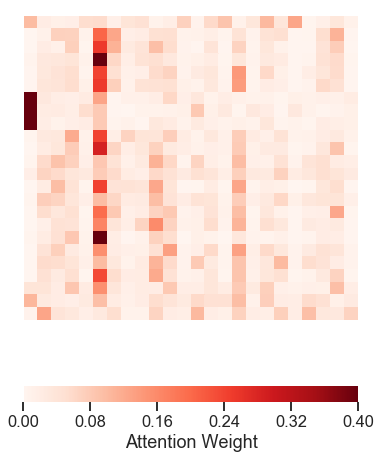

In [13]:
f, ax = plt.subplots(figsize=(6,8))
sns.heatmap(map1, annot=False, fmt="f", ax=ax, xticklabels = False, yticklabels = False, vmax=0.4, cmap='Reds', cbar_kws={'label':'Attention Weight', 'orientation':'horizontal'}, rasterized = True)

<Figure size 432x288 with 0 Axes>

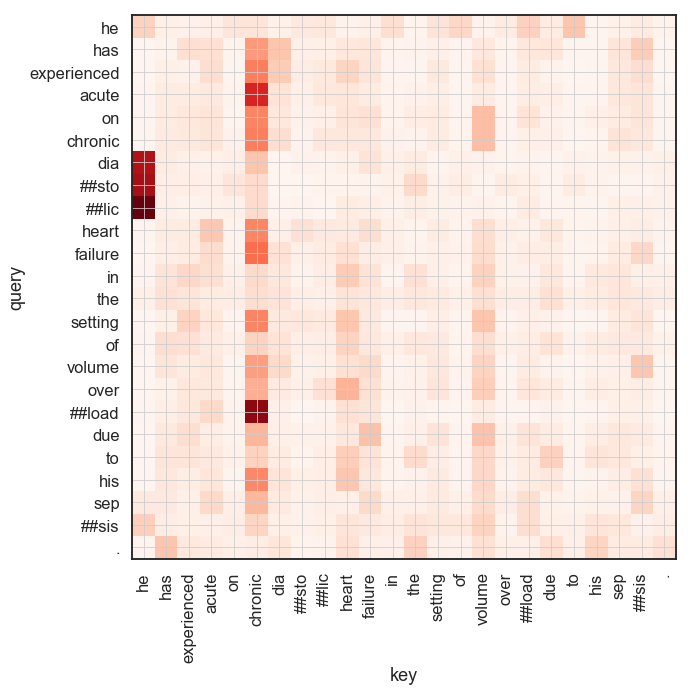

In [14]:
plt.clf()

f=plt.figure(figsize=(10,10))
ax = f.add_subplot(1,1,1)
i=ax.imshow(map1,interpolation='nearest',cmap='Reds')

ax.set_yticks(range(len(tokens)))
ax.set_yticklabels(tokens)

ax.set_xticks(range(len(tokens)))
ax.set_xticklabels(tokens, rotation=90)

ax.set_xlabel('key')
ax.set_ylabel('query')

ax.grid(linewidth = 0.8)

# Long-range interactions (Optional)
If you're interested in visualizing long-range interactions in clinical notes, you can enter a long chunk of text taken from a patient's NOTEEVENTS file. However, because the dataset is private, in order to protect its privacy I will not show the exact text that I used to create the graph below.

In [15]:
text = 'Here you can enter your confidential notes from mimic iii but just be sure it does not exceed 512'.

In [16]:
x,tokens=get_attention_scores(model,0,text)
map1=np.asarray(x[0][1].detach().numpy())

Text(68.0, 0.5, 'Query Tokens')

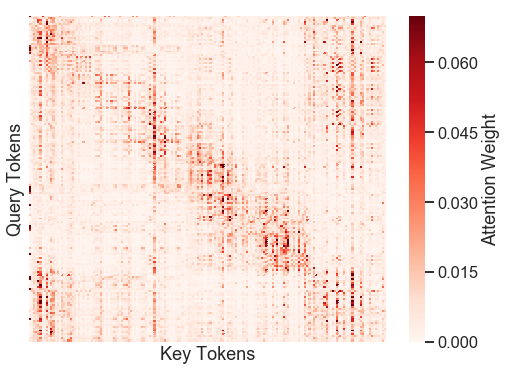

In [17]:
f, ax = plt.subplots(figsize=(8,6))

sns.heatmap(map1, annot=False, fmt="f", ax=ax, xticklabels = False, yticklabels = False, vmin=0, vmax=0.07, cmap='Reds', cbar_kws={'label':'Attention Weight'})

ax.set_xlabel('Key Tokens')
ax.set_ylabel('Query Tokens')